In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import ModelClass
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearnex import patch_sklearn
#patch_sklearn(verbose=False)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### Loading the Data

In [2]:
X = pd.read_csv('data/Training-set-values.csv')
y = pd.read_csv('data/Training-set-labels.csv')

X['date_recorded'] = pd.to_datetime(X['date_recorded']).astype(np.int64)

#### Preprocessors

In [3]:
# Super basic numeric transformer

numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='median'))]
)

numeric_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, make_column_selector(dtype_include=np.number)),
    ]
)

### Models

In [4]:
# # kNearestNeighbors
# kNearestNeighbors = {'classifier': KNeighborsClassifier(n_jobs=3), 'preprocessor': None}

# # Logistic Regressoion
# LogisticRegressionModel = {'classifier': LogisticRegression(C=1e6, n_jobs=3), 'preprocessor': None}

# # Decision Trees
# DecisionTrees = {'classifier': DecisionTreeClassifier(),'preprocessor': None}
# # Decision Trees - adjusted
# DecisionTreesAdjusted = {'classifier': DecisionTreeClassifier(criterion=['gini','entropy'], max_depth=[90,100], min_samples_split=[2,3], class_weight='balanced'),'preprocessor': numeric_preprocessor}

# Random Forest with numeric processor
RandomFM_1 = {'classifier': RandomForestClassifier(max_depth=20, min_samples_split=4, n_jobs=3), 'preprocessor': numeric_preprocessor}
# # Random Forest no processor
# RandomFM_2 = {'classifier': RandomForestClassifier(max_depth=20, min_samples_split=4, n_jobs=3), 'preprocessor': None}
# # Random Forest default
# # Included for RandomCVSearch later on
#RandomFM_rs = {'classifier': RandomForestClassifier(n_jobs=3), 'preprocessor': None}

models = {#'kNearestNeighbors': kNearestNeighbors,
    #'LogisticRegression': LogisticRegressionModel,
    #'DecisionTrees': DecisionTrees,
    #'DecisionTreesAdjusted': DecisionTreesAdjusted,
        'RandomFM_1': RandomFM_1}
    #'RandomFM_2': RandomFM_2,
    #'RandomFM_rs': RandomFM_rs}


### Modeler

In [5]:
model_run = ModelClass.Modeler(models, X=X, y=y)

# Adding in after the model_run object is created so we can add onto the default preprocessor.
log_reg_regularized = {'classifier': LogisticRegression(n_jobs=3), 'preprocessor': model_run.create_default_prep(num_add=[('scaling', StandardScaler())])}
model_run.add_model('log_reg_regularized', log_reg_regularized)

In [6]:
model_run._X_train.shape

(44550, 40)

### Search parameters and kwargs

In [7]:
kNN_params = dict(leaf_size=[1,50],
                    n_neighbors=[1,30], 
                    p=[1,2])
                    
LogRegRCV_params = dict(penalty=['l1', 'l2', 'elasticnet'],
                        C=stats.uniform(loc=1, scale=10),
                        max_iter=list(range(100,400)))

DecisionTree_params = dict(criterion=['gini', 'entropy'],
                        max_depth = list(range(20,50)),
                        min_samples_split = list(range(2, 10)))

RandForestRCV_params = dict(n_estimators=list(range(100,300)),
                            criterion=['gini', 'entropy'],
                            max_depth = list(range(20,50)),
                            min_samples_split = list(range(2, 10)))

search_options = {'n_jobs': 3, 'random_state': 9280210, 'n_iter': 20}

## Training LogisticRegression Model

In [8]:
#model_run.train_model('LogisticRegression')

## RandomizedSearchCV

In [9]:
#model_run.hyper_search('kNearestNeighbors', params=kNN_params, searcher_kwargs=search_options, set_to_train=True)

In [10]:
model_run.hyper_search('log_reg_regularized', params=LogRegRCV_params, searcher_kwargs=search_options, set_to_train=True)

In [11]:
#model_run.hyper_search('DecisionTrees', params=DecisionTree_params, searcher_kwargs=search_options, set_to_train=True)

In [12]:
#model_run.hyper_search('DecisionTreesAdjusted', params=DecisionTree_params, searcher_kwargs=search_options, set_to_train=True)

In [13]:
model_run.hyper_search('RandomFM_1', params=RandForestRCV_params, searcher_kwargs=search_options, set_to_train=True)

In [14]:
#model_run.hyper_search('RandomFM_2', params=RandForestRCV_params, searcher_kwargs=search_options, set_to_train=True)

In [15]:
#model_run.hyper_search('RandomFM_rs', params=RandForestRCV_params, searcher_kwargs=search_options, set_to_train=True)

## Test Models

In [16]:
model_run.test_all()

## Plotting

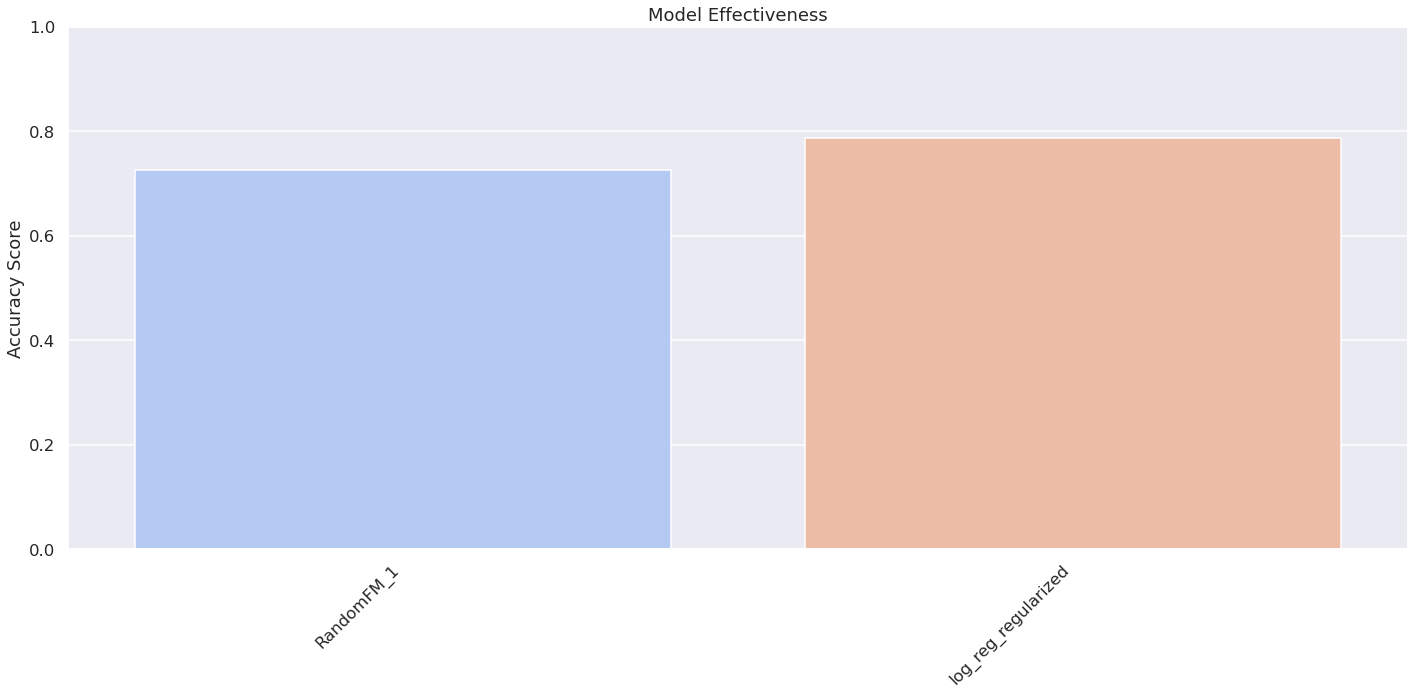

In [17]:
model_run.plot_models()

## Modeler

### Random Forests

In [18]:
model_run.model_evaluation('RandomFM_1')

root - INFO - Cross validate scores for RandomFM_1: [0.71784512 0.71986532 0.72390572 0.71773288 0.71806958]
root - INFO - RandomFM_1 has been fit.
root - INFO - RandomFM_1 test score: 0.7243097643097643


------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------


KeyError: 'train_output'

root - INFO - Model RandomFM_1 has permutation importances of construction_year        0.071690
amount_tsh               0.062781
latitude                 0.049232
longitude                0.046862
date_recorded            0.039805
population               0.036801
gps_height               0.024653
region_code              0.019717
district_code            0.014101
waterpoint_type_group    0.000000
dtype: float64


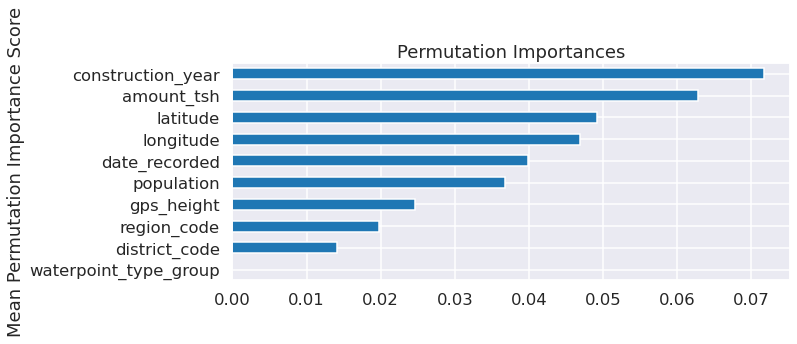

In [19]:
importance_kwargs = dict(n_repeats=10, n_jobs=3)
model_run.permutation_importance('RandomFM_1', perm_kwargs=importance_kwargs)